# ICARE CEBRA Pipeline
Full pipeline for CPC prediction using CEBRA embeddings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import sys
sys.path.append('scripts')

from prepare_data import load_and_merge_data, prepare_train_test_split, save_splits
from train import train_cebra
from evaluate import evaluate_model
from visualize import plot_embedding, plot_train_test
from cebra import CEBRA

## 1. Data Preparation
Merge neural data with CPC labels and create train/test splits

In [2]:
# Load and merge neural data with labels
# Returns: DataFrame with neural features + CPC labels
merged = load_and_merge_data(
    neural_dir="1000_ICARE_patient_10s_94f_with_spike",
    labels_path="labels/ICARE_clinical.csv"
)

print(f"\nMerged data shape: {merged.shape}")
print(f"CPC distribution:\n{merged['cpc_bin'].value_counts()}")

Neural data: 39715 samples
Labels: 1086 patients
Merged: 39715 samples

Merged data shape: (39715, 108)
CPC distribution:
cpc_bin
good    25962
poor    13753
Name: count, dtype: int64


In [3]:
# Split at patient level, stratified by cpc_bin
# Ensures no patient appears in both train and test
# NaN handling: 'drop' (remove samples), 'mean', 'median', 'zero', 'ffill'
# Returns: train_data, test_data dictionaries with keys:
#   - neural: (n_samples, n_features)
#   - cpc: continuous CPC scores
#   - cpc_bin: binary labels (0=good, 1=poor)
#   - patient_ids: numeric patient IDs

train_data, test_data = prepare_train_test_split(
    merged, 
    test_size=0.2,  # Adjusted automatically for small datasets
    seed=42,
    nan_strategy='mean'  # Options: drop, mean, median, zero, ffill
)

# Save splits
save_splits(train_data, test_data, output_dir='data')

Adjusted test_size to 0.50 (2 patients)
  NaN values: 17830 (1.04%)
  NaN values: 186 (0.01%)

Train: 18055 samples, 2 patients
  cpc_bin distribution: [8448 9607]
Test: 21660 samples, 2 patients
  cpc_bin distribution: [17514  4146]

✓ Saved: data/train.npz
✓ Saved: data/test.npz


In [ ]:
# Highlight NaN locations in neural features
meta_cols = ['patient', 'seg_no', 'file', 'row_in_seg', 'rel_sec', 'pat_ICARE', 'cpc', 'cpc_bin', 'ROSC(minutes)', 'age', 'sex', 'vfib', 'time_to_CA(seconds)']
feature_cols = [col for col in merged.columns if col not in meta_cols]

# Show NaN pattern (sample 1000 rows for visualization)
sample_df = merged[feature_cols].iloc[::40]  # Every 40th row
styled = sample_df.style.apply(lambda x: ['background-color: red' if pd.isna(v) else '' for v in x], axis=0)
styled

In [ ]:
# View merged data as DataFrame
merged.head(10)

In [ ]:
# Train CEBRA model
# Args:
#   - neural_data: (n_samples, n_features)
#   - labels: single or multiple labels
#     - Single: cpc_bin or cpc
#     - Multiple: np.column_stack([cpc, cpc_bin])
#   - output_path: where to save model
#   - max_iter: training iterations (default: 5000)
#   - output_dim: embedding dimensions (default: 8)
#   - seed: random seed (default: 42)
# Returns: model, embedding

# Single label
model, train_embedding = train_cebra(
    neural_data=train_data['neural'],
    labels=train_data['cpc_bin'],  # Or: train_data['cpc'] or np.column_stack([train_data['cpc'], train_data['cpc_bin']])
    output_path='models/cebra_model.pt',
    max_iter=5000,
    output_dim=8,
    seed=42
)

## 2. Training
Train CEBRA model on training data with CPC labels

In [5]:
# Train CEBRA model
# Args:
#   - neural_data: (n_samples, n_features)
#   - labels: cpc or cpc_bin
#   - output_path: where to save model
#   - max_iter: training iterations (default: 5000)
#   - output_dim: embedding dimensions (default: 8)
#   - seed: random seed (default: 42)
# Returns: model, embedding

model, train_embedding = train_cebra(
    neural_data=train_data['neural'],
    labels=train_data['cpc_bin'],  # Change to 'cpc' for continuous
    output_path='models/cebra_model.pt',
    max_iter=5000,
    output_dim=3,
    seed=42
)

pos: -0.7709 neg:  6.5710 total:  5.8001 temperature:  1.1200: 100%|██████████| 5000/5000 [04:18<00:00, 19.36it/s]



✓ Model: models/cebra_model.pt
  Embedding: (18055, 3), Device: cpu


In [ ]:
# Evaluate model performance
# Uses KNN classifier (k=5)
# Returns: dict with train/test accuracy and AUC (binary only)

results = evaluate_model(
    model_path='models/cebra_model.pt',
    train_data=train_data,
    test_data=test_data,
    label_key='cpc_bin'  # Match training label
)

print("\nEvaluation Results:")
for key, val in results.items():
    if isinstance(val, float):
        print(f"  {key}: {val:.4f}")
    else:
        print(f"  {key}: {val}")

## 3. Evaluation
Evaluate decoding performance on train and test sets

In [7]:
# Evaluate model performance
# Uses KNN classifier for binary labels (cpc_bin)
# Uses KNN regressor for continuous labels (cpc)
# Returns: dict with train/test accuracy (or R2) and AUC

results = evaluate_model(
    model_path='models/cebra_model.pt',
    train_data=train_data,
    test_data=test_data,
    label_key='cpc_bin'  # Match training label
)

print("\nEvaluation Results:")
for key, val in results.items():
    if isinstance(val, float):
        print(f"  {key}: {val:.4f}")
    else:
        print(f"  {key}: {val}")


Evaluation Results:
  task: classification
  train_accuracy: 0.9742
  test_accuracy: 0.2539
  train_auc: 0.9975
  test_auc: 0.2060
  model_path: models/cebra_model.pt
  train_shape: (18055, 3)
  test_shape: (21660, 3)


## 4. Visualization
Plot embeddings colored by CPC labels

✓ Saved: visualizations/train_embedding.png


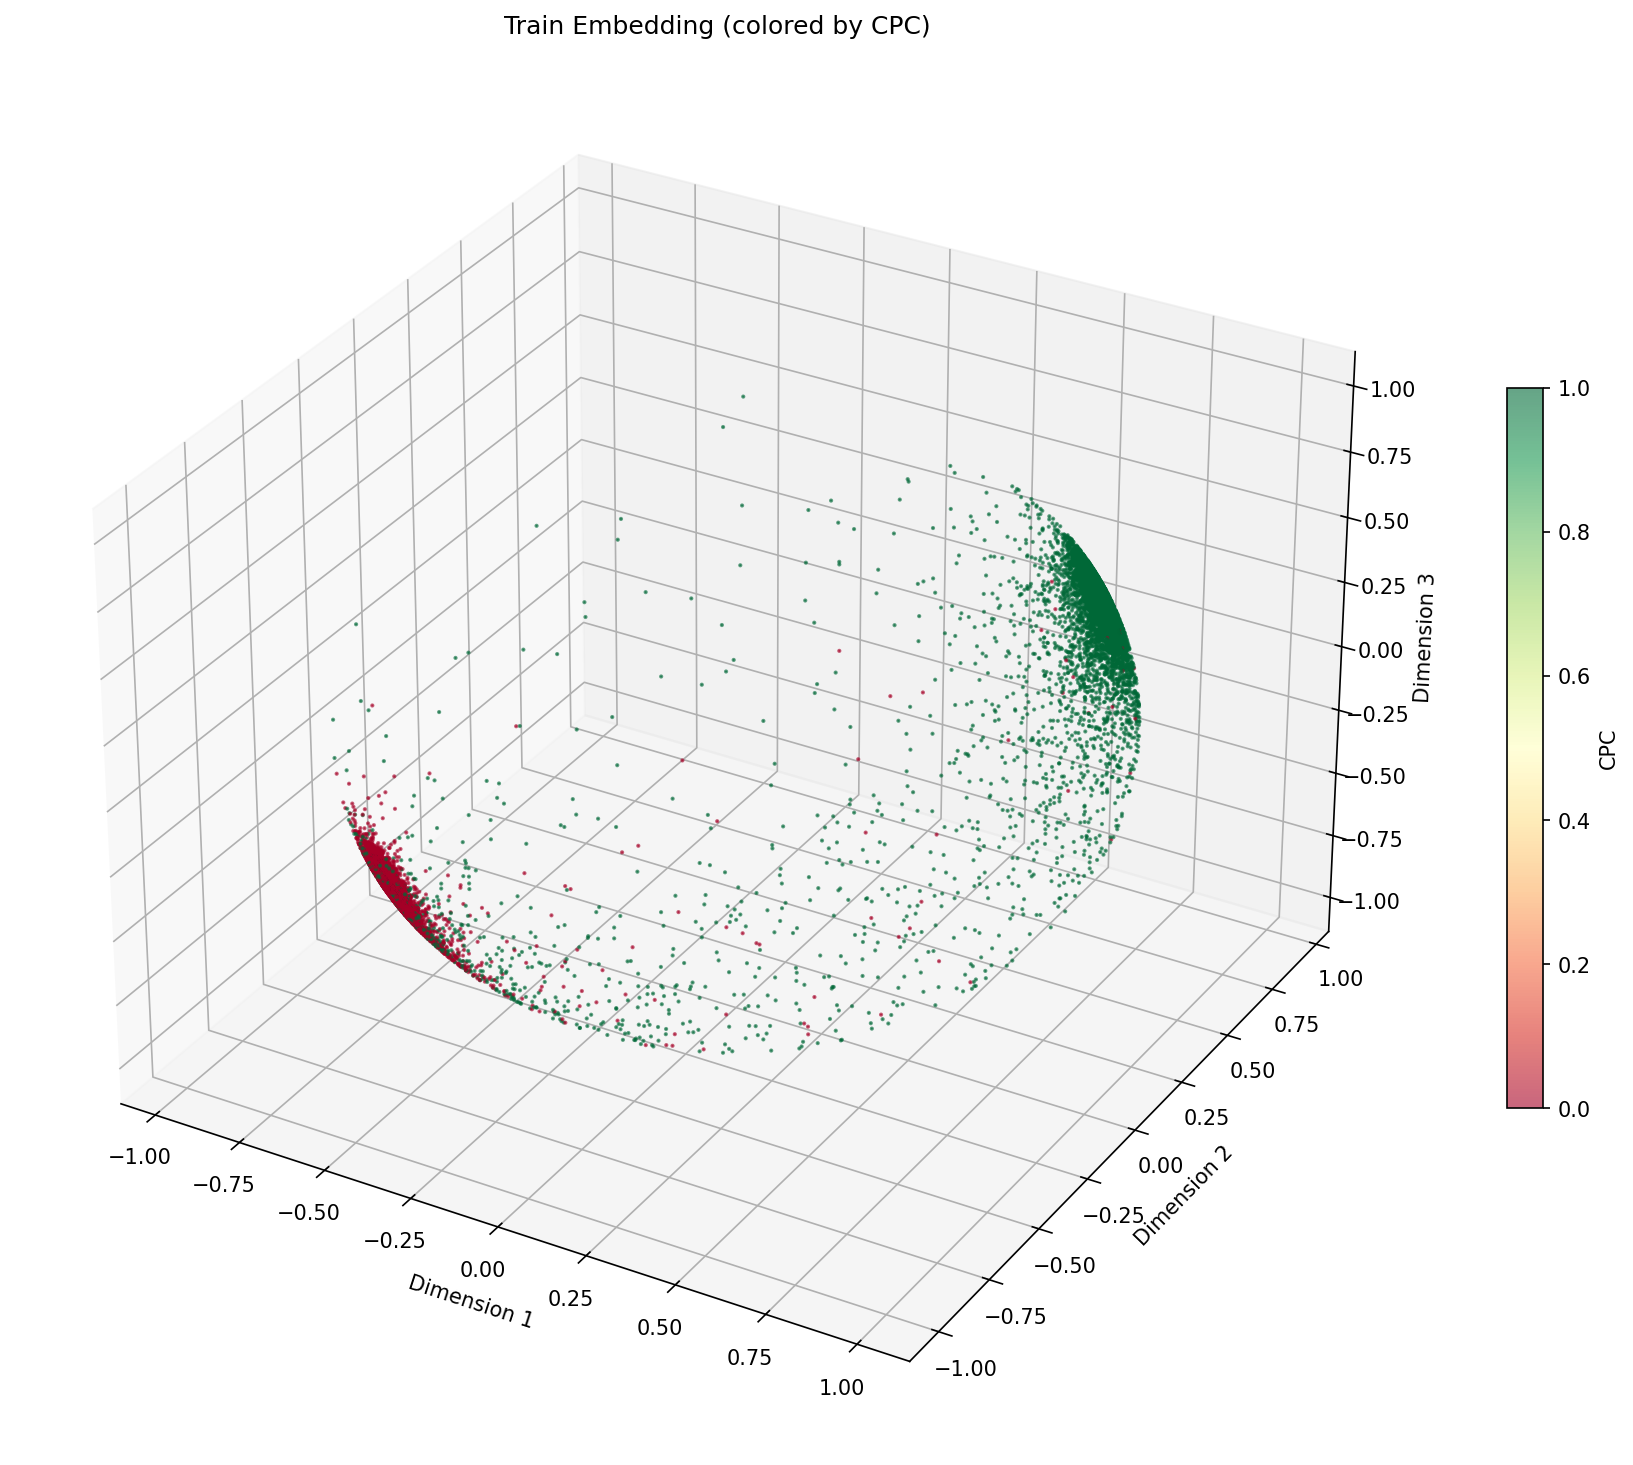

In [8]:
# Plot train embedding
# For 2D: scatter plot
# For 3D+: uses first 3 dimensions

plot_embedding(
    embedding=train_embedding,
    labels=train_data['cpc_bin'],
    title='Train Embedding (colored by CPC)',
    output_path='visualizations/train_embedding.png'
)

Image(filename='visualizations/train_embedding.png')

✓ Saved: visualizations/test_embedding.png


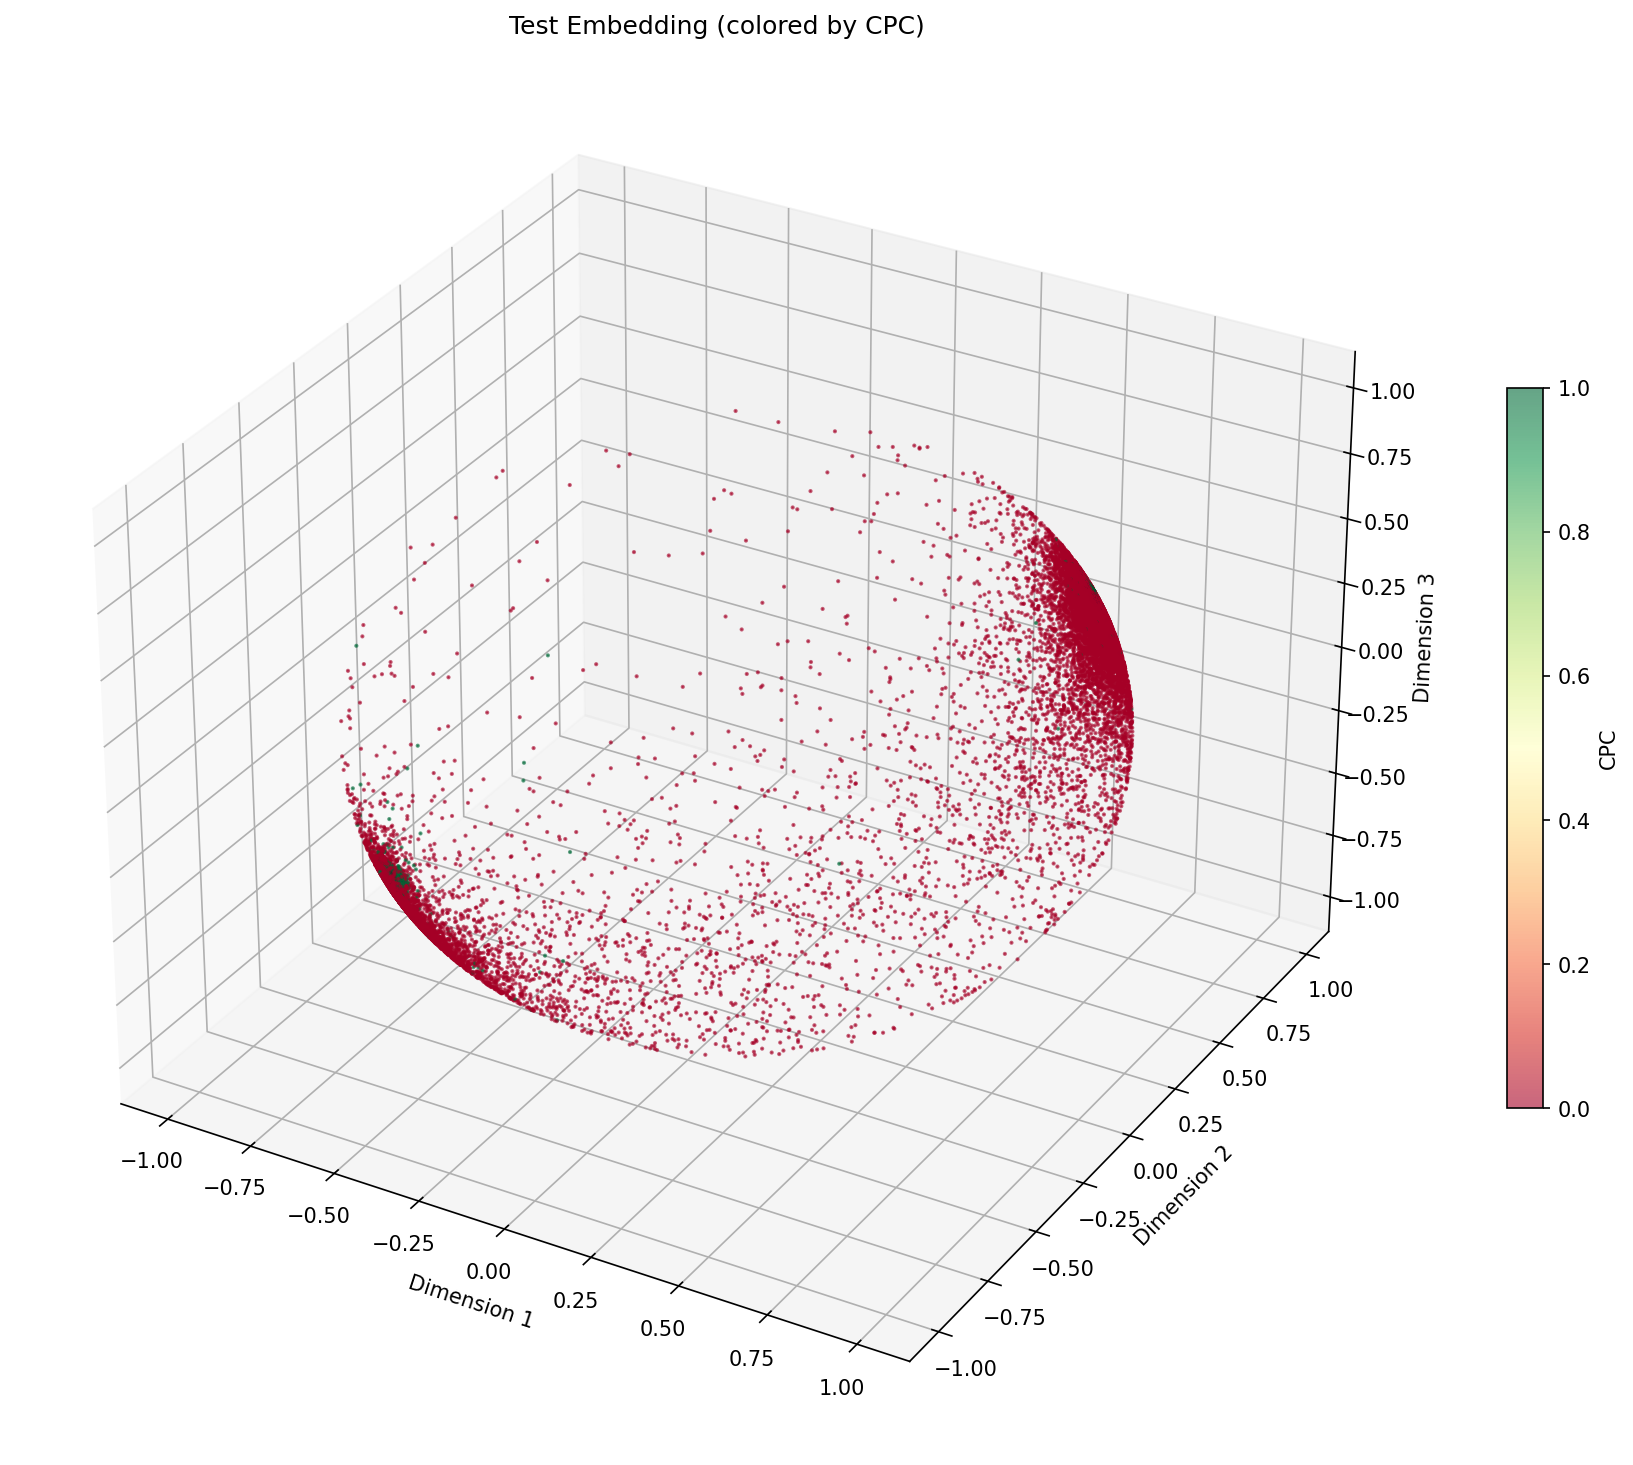

In [9]:
# Plot test embedding
plot_embedding(
    embedding=test_embedding,
    labels=test_data['cpc_bin'],
    title='Test Embedding (colored by CPC)',
    output_path='visualizations/test_embedding.png'
)

Image(filename='visualizations/test_embedding.png')

/app/scripts/visualize.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved: visualizations/train_test_comparison.png


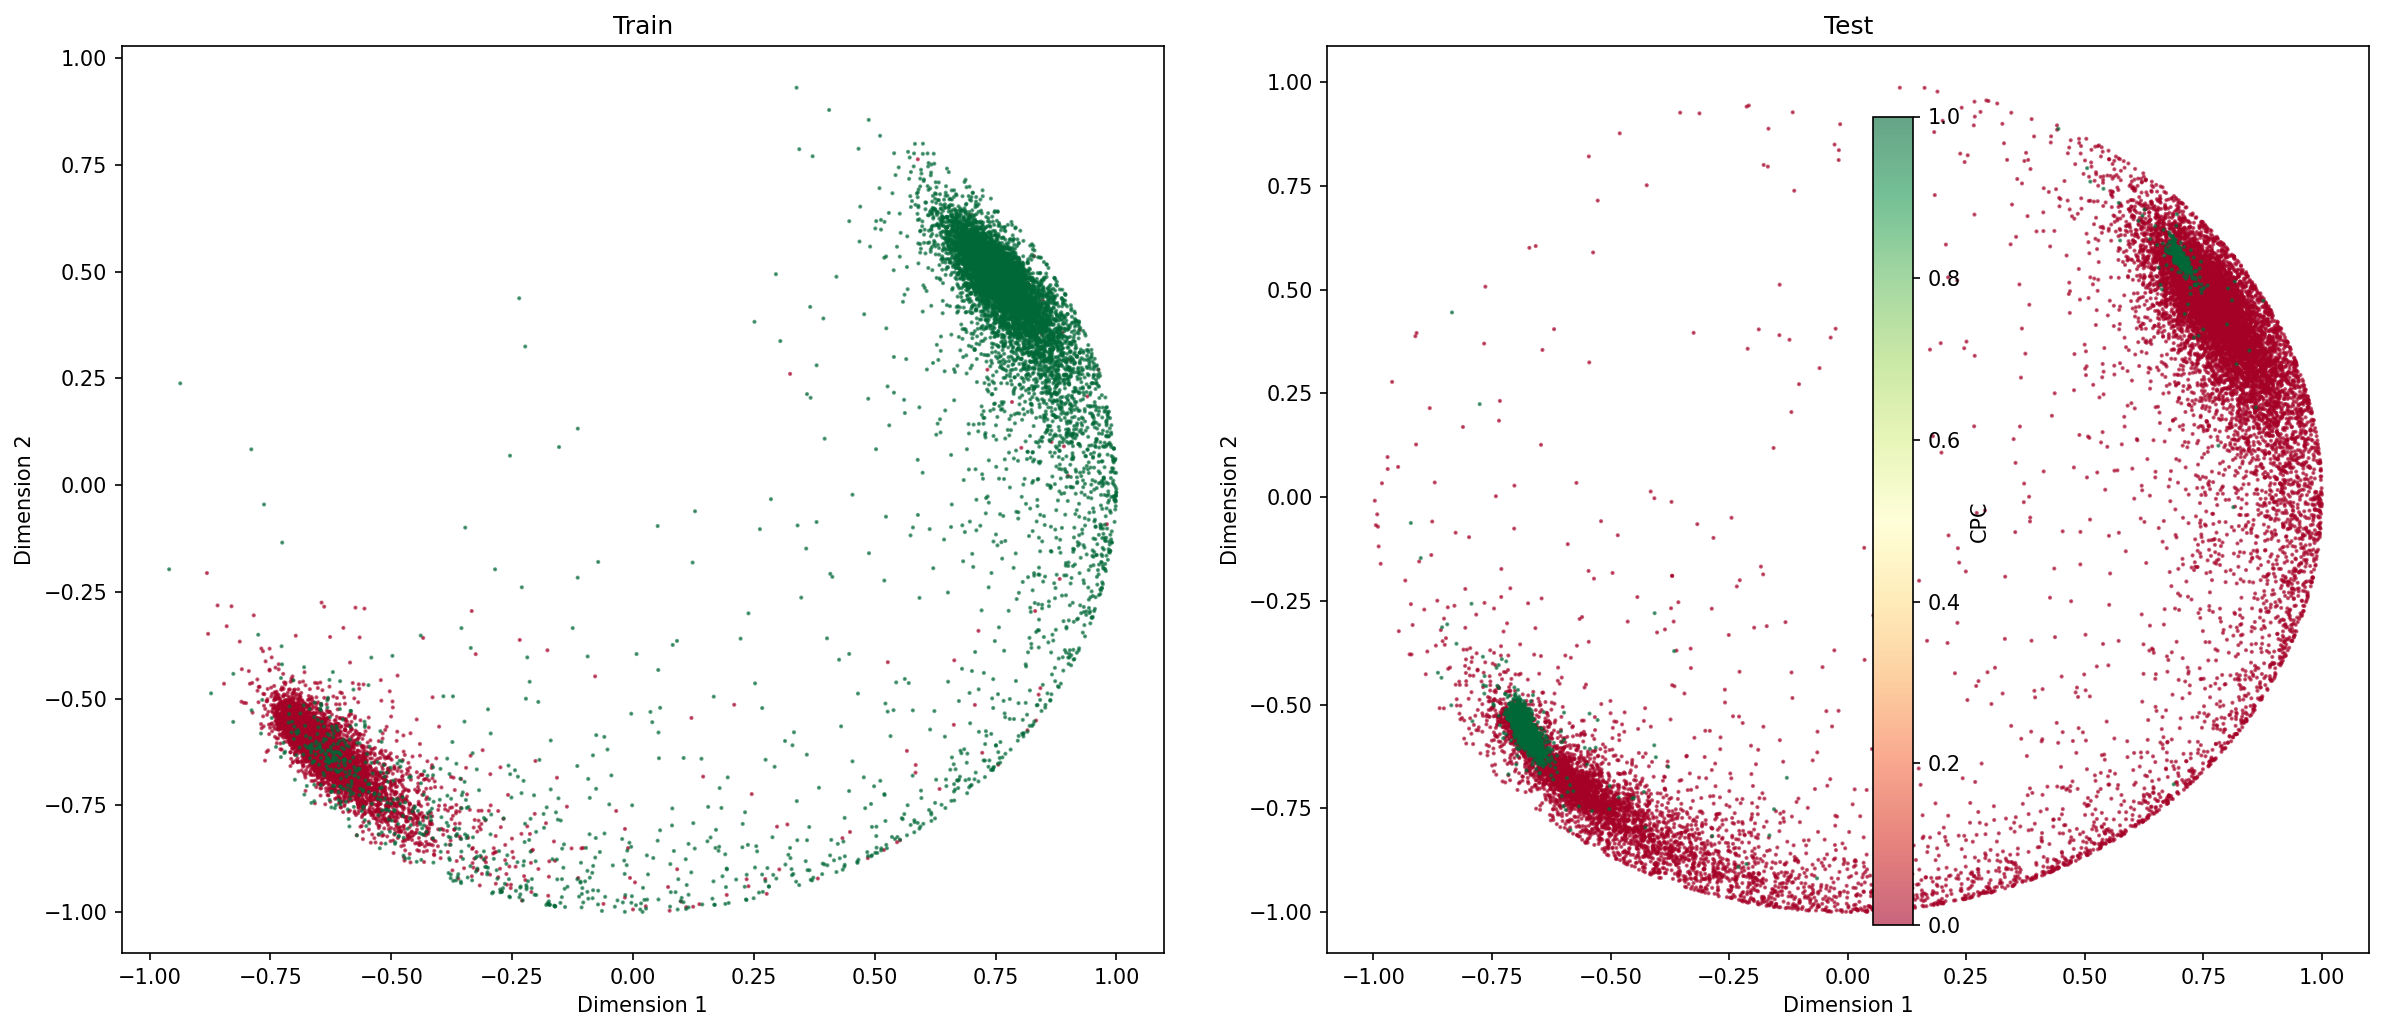

In [10]:
# Plot train and test side by side
# Only works for embeddings with 2+ dimensions

plot_train_test(
    train_emb=train_embedding,
    test_emb=test_embedding,
    train_labels=train_data['cpc_bin'],
    test_labels=test_data['cpc_bin'],
    output_path='visualizations/train_test_comparison.png'
)

Image(filename='visualizations/train_test_comparison.png')

## 5. Hyperparameter Tuning (Optional)
Grid search over learning rate, temperature, dimensions, iterations

In [ ]:
from tune import tune_hyperparameters

# Define parameter grid
# Smaller grid for faster search
param_grid = {
    'learning_rate': [3e-4, 1e-3],
    'temperature': [1.0, 1.12],
    'output_dimension': [3, 8],
    'max_iterations': [3000, 5000]
}

# Run grid search
# Each config trained n_runs times for consistency
# Returns: list of dicts sorted by avg_loss

tune_results = tune_hyperparameters(
    neural_data=train_data['neural'],
    labels=train_data['cpc_bin'],
    param_grid=param_grid,
    output_path='tuning/results.json',
    n_runs=3
)

Testing 16 configs x 3 runs

[1/16] {'learning_rate': 0.0003, 'temperature': 1.0, 'output_dimension': 3, 'max_iterations': 3000}


In [ ]:
# Show top 3 configs
print("\nTop 3 Configurations:")
for i, result in enumerate(tune_results[:3]):
    print(f"\n{i+1}. Loss: {result['avg_loss']:.4f} ± {result['std_loss']:.4f}")
    print(f"   Config: {result['config']}")

## 6. Load Existing Model
Load previously trained model for inference

In [ ]:
import torch

# Custom CEBRA configuration
custom_model = CEBRA(
    model_architecture='offset10-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.12,
    max_iterations=3000,  # Fewer iterations
    time_offsets=10,
    output_dimension=3,   # Lower dimension
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=True
)

# Train with multiple labels
multi_labels = np.column_stack([train_data['cpc'], train_data['cpc_bin']])
custom_model.fit(train_data['neural'], multi_labels)

# Transform
custom_embedding = custom_model.transform(test_data['neural'])
print(f"Custom embedding: {custom_embedding.shape}")

## 7. Custom Training
Manually configure CEBRA parameters

In [ ]:
import torch

# Custom CEBRA configuration
custom_model = CEBRA(
    model_architecture='offset10-model',
    batch_size=512,
    learning_rate=3e-4,
    temperature=1.12,
    max_iterations=3000,  # Fewer iterations
    time_offsets=10,
    output_dimension=3,   # Lower dimension
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=True
)

# Train
custom_model.fit(train_data['neural'], train_data['cpc'])

# Transform
custom_embedding = custom_model.transform(test_data['neural'])
print(f"Custom embedding: {custom_embedding.shape}")